In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize # to normalize the data;
import faiss # pip i faiss_cpu
import time
from mpl_toolkits.mplot3d import Axes3D

In [18]:
def generate_sample_vectors(n_vectors=100, n_dimensions=3, seed=42):  # generating the synthetic vectors --> not original data, false data;
    np.random.seed(seed)
    vectors = np.random.randn(n_vectors, n_dimensions)
    normalized_vectors = normalize(vectors, norm='l2')
    return normalized_vectors


# just plotting the just created synthetic vector : 
def plot_vectors_3d(vectors, query_vector=None, matches=None, title="Vector Space Visualization"):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d') # --> 3D visualization
    
    # plotting all vectors
    ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c='red', alpha=0.5, label='Database vectors')
    
    # plotting the query vector if provided
    if query_vector is not None:
        ax.scatter(query_vector[0], query_vector[1], query_vector[2], 
                  c='green', s=100, label='Query vector')
    
    # plotting matches if provided
    if matches is not None:
        match_vectors = vectors[matches]
        ax.scatter(match_vectors[:, 0], match_vectors[:, 1], match_vectors[:, 2], 
                  c='blue', s=100, label='Matches')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()



# plotting the just created synthetic vectors with regions/clusters in 3D, needed for the FAISS visualization --> done in copy (freehand)
def plot_vectors_with_regions(vectors, centroids, query_vector=None, matches=None, 
                            searched_regions=None, title="Vector Space with FAISS Regions"):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Assign each vector to nearest centroid
    distances, assignments = compute_vector_assignments(vectors, centroids)
    
    # Plot vectors colored by their cluster
    colors = plt.cm.rainbow(np.linspace(0, 1, len(centroids)))
    for i in range(len(centroids)):
        cluster_vectors = vectors[assignments == i]
        if len(cluster_vectors) > 0:
            # Make vectors transparent if their region wasn't searched
            alpha = 1.0 if searched_regions is None or i in searched_regions else 0.1
            ax.scatter(cluster_vectors[:, 0], cluster_vectors[:, 1], cluster_vectors[:, 2], 
                      c=[colors[i]], alpha=alpha, label=f'Region {i}')
    
    # Plot centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
              c='black', s=100, marker='*', label='Region Centers')
    
    # Plot query vector
    if query_vector is not None:
        ax.scatter(query_vector[0], query_vector[1], query_vector[2], 
                  c='red', s=200, marker='x', label='Query Vector')
    
    # Plot matches
    if matches is not None:
        match_vectors = vectors[matches]
        ax.scatter(match_vectors[:, 0], match_vectors[:, 1], match_vectors[:, 2], 
                  c='green', s=100, label='Matches')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()


In [19]:
# which vector belongs to which centeroid,
def compute_vector_assignments(vectors, centroids):
    index = faiss.IndexFlatL2(vectors.shape[1]) # indexing using FAISS-INDEXFLATL2 method
    index.add(centroids)
    distances, assignments = index.search(vectors, 1)
    return distances, assignments.ravel()

# creating the clusters using K-Mean Algorithm
def train_kmeans_get_centroids(vectors, n_clusters):
    kmeans = faiss.Kmeans(d=vectors.shape[1], k=n_clusters, niter=20, verbose=False)
    kmeans.train(vectors)
    return kmeans.centroids

In [20]:
# real funcs for the approchs = 

In [36]:
# this is brute force cosine search : 
def brute_force_cosine_search(database_vectors, query_vector, k=5):
    start_time = time.time()
    similarities = np.dot(database_vectors, query_vector)
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    end_time = time.time()
    return top_k_indices, end_time - start_time

In [37]:
# this is FAISS-INDEXFLATL2 : 
def faiss_flat_l2_search(database_vectors, query_vector, k=5):
    dimension = database_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)
    
    start_time = time.time()
    index.add(database_vectors)
    distances, indices = index.search(query_vector.reshape(1, -1), k)
    end_time = time.time()
    
    return indices[0], end_time - start_time


In [38]:
# this is FAISS-INDEXIVF
def faiss_ivf_search_realistic(database_vectors, query_vectors, k=5, n_regions=10, nprobe=3):
    dimension = database_vectors.shape[1]
    
    # Create and train index (this would normally be done once and saved)
    print("Training index (this is usually done once)...")
    quantizer = faiss.IndexFlatL2(dimension)
    index = faiss.IndexIVFFlat(quantizer, dimension, n_regions, faiss.METRIC_L2)
    
    train_start = time.time()
    index.train(database_vectors)
    train_time = time.time() - train_start
    
    # Add vectors (this is also usually done once)
    add_start = time.time()
    index.add(database_vectors)
    add_time = time.time() - add_start
    
    # Set number of regions to search
    index.nprobe = nprobe
    
    # Actual search (this is what we'd do many times)
    search_start = time.time()
    distances, indices = index.search(query_vectors, k)
    search_time = time.time() - search_start
    
    return indices, search_time, train_time, add_time



In [39]:
# main code starts from here,

In [40]:
# step 1 : generating the synthetic dataset using the functions,

n_vectors = 1000
n_dimensions = 3  # Using 3D for visualization
k = 7
print(f"Generating {n_vectors} vectors with {n_dimensions} dimensions...")
database_vectors = generate_sample_vectors(n_vectors, n_dimensions)


Generating 1000 vectors with 3 dimensions...


In [41]:
print(database_vectors)

[[ 0.60000205 -0.1670153   0.78237039]
 [ 0.97717133 -0.15023209 -0.15022156]
 [ 0.86889694  0.42224942 -0.25830898]
 ...
 [ 0.93719207  0.11212477 -0.33030147]
 [-0.96227616  0.07832357  0.26055711]
 [-0.95868168  0.25799564 -0.1198653 ]]


In [42]:
# step 2 : randomly generating a query vector,

query_vector = generate_sample_vectors(1, n_dimensions)[0]
query_vector_batch = query_vector.reshape(1, -1)  # reshape for batch processing
print(query_vector)
print(query_vector_batch)

[ 0.60000205 -0.1670153   0.78237039]
[[ 0.60000205 -0.1670153   0.78237039]]



Visualizing initial vector space...


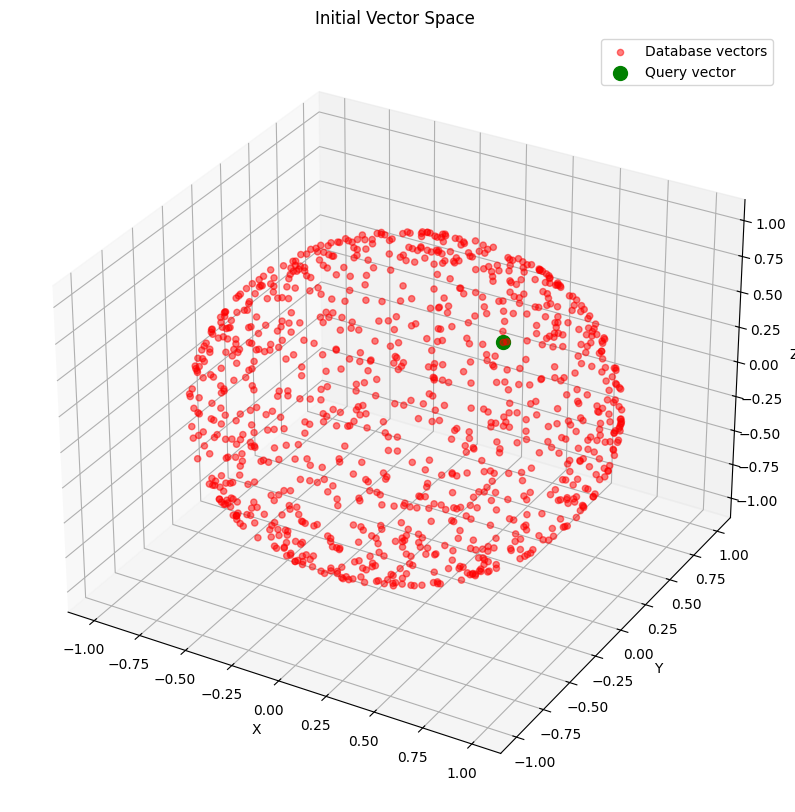

In [43]:
# step 3 : visualizing the whole synthetic dataset/vectors with a randomly selected query vector,

# 3. Visualize initial vector space
print("\nVisualizing initial vector space...")
plot_vectors_3d(database_vectors, query_vector, title="Initial Vector Space")


Performing brute force cosine similarity search...
Brute force search time: 0.000000 seconds
Top 7 cosine similarity matches (indices): [  0 653  61 273 336  71 568]


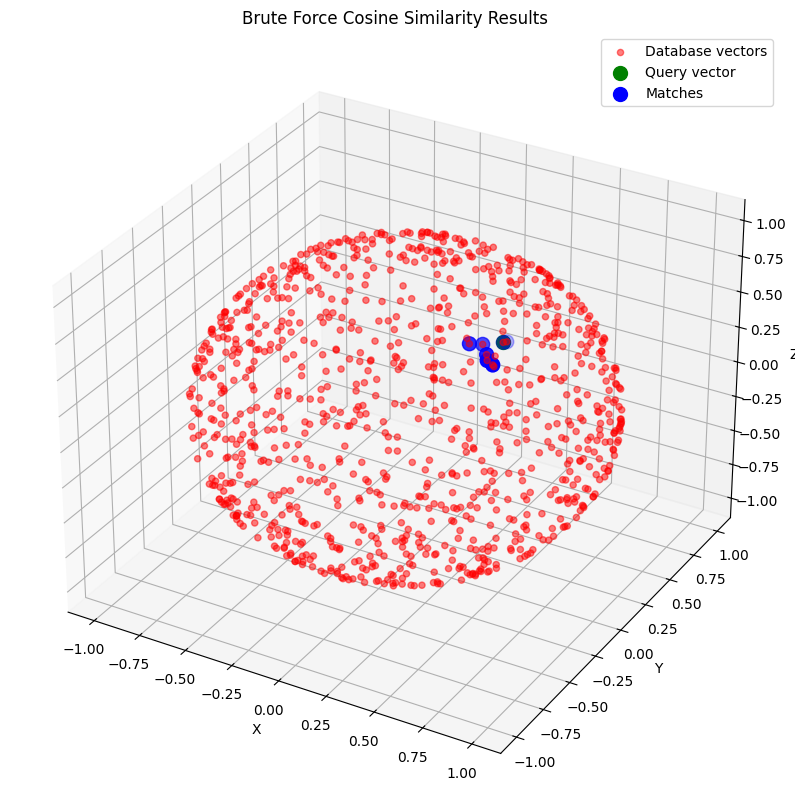

In [45]:
# step 4-A : performing brute force Cosine Similarity Search : 

print("\nPerforming brute force cosine similarity search...")
cosine_matches, cosine_time = brute_force_cosine_search(database_vectors, query_vector, k)
print(f"Brute force search time: {cosine_time:.6f} seconds")
print(f"Top {k} cosine similarity matches (indices): {cosine_matches}")

# visualizing it : 
plot_vectors_3d(database_vectors, query_vector, cosine_matches, 
               "Brute Force Cosine Similarity Results")


Performing basic FAISS L2 search...
FAISS L2 search time: 0.000999 seconds
Top 7 L2 distance matches (indices): [  0 653  61 273 336  71 568]


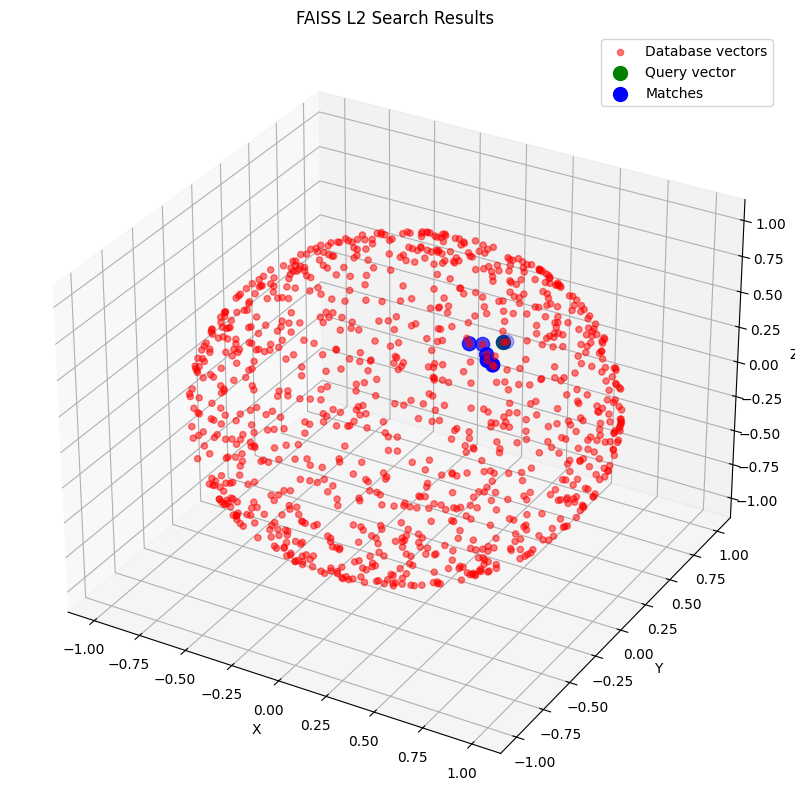

In [46]:
# step 4-B : performing FAISS-INDEXFLATL2 Search : 

print("\nPerforming basic FAISS L2 search...")
faiss_matches, faiss_time = faiss_flat_l2_search(database_vectors, query_vector, k)
print(f"FAISS L2 search time: {faiss_time:.6f} seconds")
print(f"Top {k} L2 distance matches (indices): {faiss_matches}")

# visualizing it : 
plot_vectors_3d(database_vectors, query_vector, faiss_matches, 
               "FAISS L2 Search Results")


Performing FAISS IVF search with regions...
Training index...
Training time: 0.015991 seconds
Adding vectors...
Adding time: 0.001999 seconds
Searching...
Search time: 0.001001 seconds
Total time (train + add + search): 0.018991 seconds
Search-only time: 0.001001 seconds
Searched 5 out of 15 regions: [ 4  0  2 14  6]


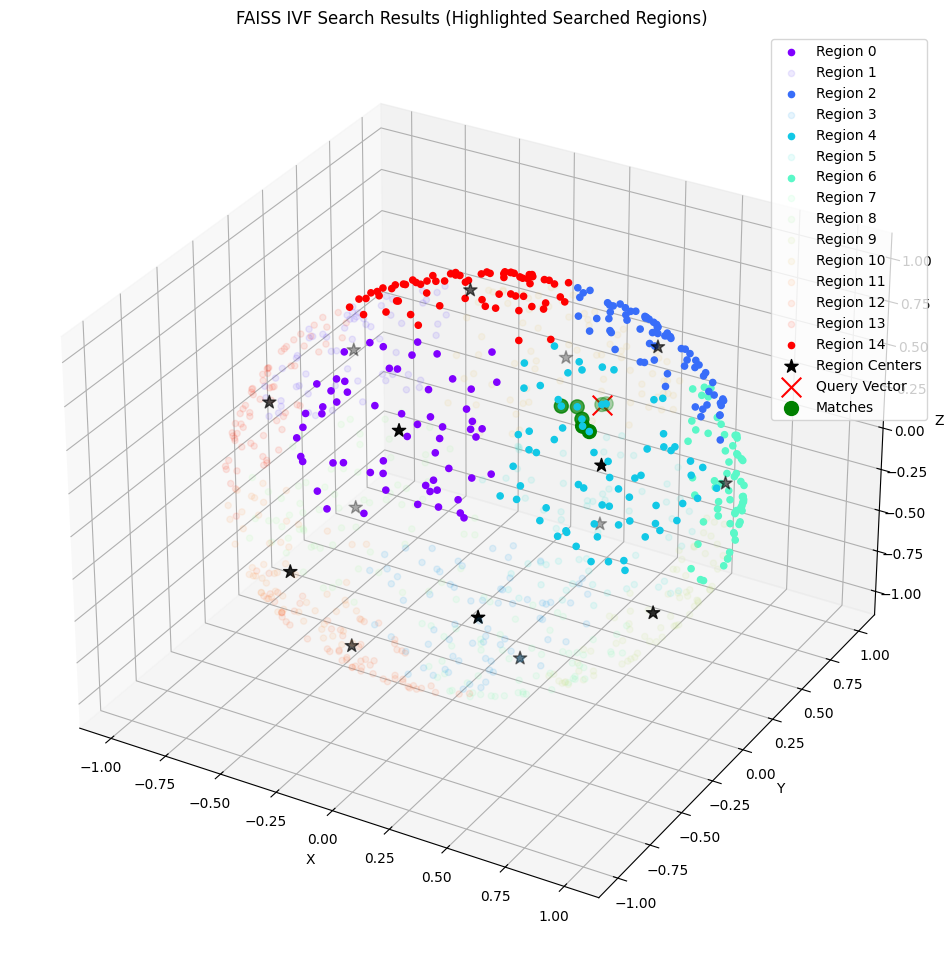

In [48]:
# step 4-C : realistic FAISS-INDEXIVF search with regions

print("\nPerforming FAISS IVF search with regions...")
n_regions = 15 # --> total number of clusters
nprobe = 5 # --> search only 3 clusters which is most suitable
 
# Create and train index
dimension = database_vectors.shape[1]
quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantizer, dimension, n_regions, faiss.METRIC_L2)

print("Training index...")
train_start = time.time()
index.train(database_vectors)
train_time = time.time() - train_start
print(f"Training time: {train_time:.6f} seconds")

print("Adding vectors...")
add_start = time.time()
index.add(database_vectors)
add_time = time.time() - add_start
print(f"Adding time: {add_time:.6f} seconds")

# setting number of regions to search
index.nprobe = nprobe

# perform search
print("Searching...")
search_start = time.time()
distances, ivf_matches = index.search(query_vector_batch, k)
search_time = time.time() - search_start
print(f"Search time: {search_time:.6f} seconds")
ivf_matches = ivf_matches[0]  # Get first batch result

# Get centroids for visualization
centroids = train_kmeans_get_centroids(database_vectors, n_regions)

# Get searched regions (approximate using nearest centroids to query)
_, searched_regions = quantizer.search(query_vector_batch, nprobe)
searched_regions = searched_regions[0]

print(f"Total time (train + add + search): {train_time + add_time + search_time:.6f} seconds")
print(f"Search-only time: {search_time:.6f} seconds")
print(f"Searched {nprobe} out of {n_regions} regions: {searched_regions}")

# 9. Visualize IVF results with regions
plot_vectors_with_regions(
    database_vectors, 
    centroids,
    query_vector, 
    ivf_matches,
    searched_regions,
    "FAISS IVF Search Results (Highlighted Searched Regions)"
)


Testing with 100 vectors and 1000 queries...
Training index (this is usually done once)...
Average times per query (seconds):
Brute Force: 0.000038
FAISS Flat: 0.000097
FAISS IVF: 0.000013

Testing with 1000 vectors and 1000 queries...
Training index (this is usually done once)...
Average times per query (seconds):
Brute Force: 0.000264
FAISS Flat: 0.000495
FAISS IVF: 0.000008

Testing with 10000 vectors and 1000 queries...
Training index (this is usually done once)...
Average times per query (seconds):
Brute Force: 0.003502
FAISS Flat: 0.011604
FAISS IVF: 0.000011

Testing with 100000 vectors and 1000 queries...
Training index (this is usually done once)...
Average times per query (seconds):
Brute Force: 0.033290
FAISS Flat: 0.112843
FAISS IVF: 0.000020


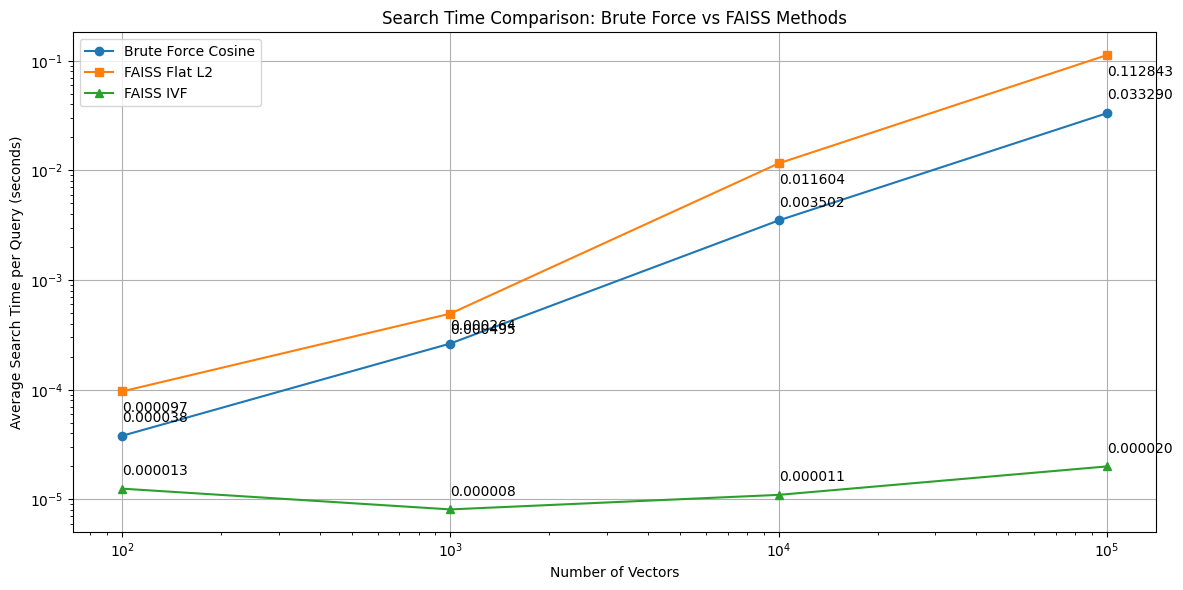

In [49]:
# Test with different vector sizes
vector_sizes = [100, 1000, 10000, 100000]
n_queries = 1000
k = 5
dimension = 128

# Dictionary to store results
results = {
    'sizes': vector_sizes,
    'brute_force': [],
    'faiss_flat': [],
    'faiss_ivf': []
}

for size in vector_sizes:
    print(f"\nTesting with {size} vectors and {n_queries} queries...")
    vectors = generate_sample_vectors(size, dimension)
    query_vectors = generate_sample_vectors(n_queries, dimension)
    
    # 1. Brute Force Cosine
    start_time = time.time()
    for query in query_vectors:
        _, _ = brute_force_cosine_search(vectors, query, k)
    brute_force_time = (time.time() - start_time) / n_queries
    results['brute_force'].append(brute_force_time)
    
    # 2. FAISS Flat L2
    start_time = time.time()
    for query in query_vectors:
        _, _ = faiss_flat_l2_search(vectors, query.reshape(1, -1), k)
    faiss_flat_time = (time.time() - start_time) / n_queries
    results['faiss_flat'].append(faiss_flat_time)
    
    # 3. FAISS IVF
    n_regions = min(size // 100, 1000)
    _, search_time, _, _ = faiss_ivf_search_realistic(vectors, query_vectors, k, n_regions)
    faiss_ivf_time = search_time / n_queries
    results['faiss_ivf'].append(faiss_ivf_time)
    
    print(f"Average times per query (seconds):")
    print(f"Brute Force: {brute_force_time:.6f}")
    print(f"FAISS Flat: {faiss_flat_time:.6f}")
    print(f"FAISS IVF: {faiss_ivf_time:.6f}")

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(results['sizes'], results['brute_force'], 'o-', label='Brute Force Cosine')
plt.plot(results['sizes'], results['faiss_flat'], 's-', label='FAISS Flat L2')
plt.plot(results['sizes'], results['faiss_ivf'], '^-', label='FAISS IVF')

plt.xscale('log')  # Log scale for vector sizes
plt.yscale('log')  # Log scale for times

plt.xlabel('Number of Vectors')
plt.ylabel('Average Search Time per Query (seconds)')
plt.title('Search Time Comparison: Brute Force vs FAISS Methods')
plt.grid(True)
plt.legend()

# Add value annotations
for i, size in enumerate(results['sizes']):
    plt.annotate(f'{results["brute_force"][i]:.6f}', 
                (size, results['brute_force'][i]), 
                textcoords="offset points", xytext=(0,10))
    plt.annotate(f'{results["faiss_flat"][i]:.6f}', 
                (size, results['faiss_flat'][i]), 
                textcoords="offset points", xytext=(0,-15))
    plt.annotate(f'{results["faiss_ivf"][i]:.6f}', 
                (size, results['faiss_ivf'][i]), 
                textcoords="offset points", xytext=(0,10))

plt.tight_layout()
plt.show()